In [34]:
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from pandas import read_csv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

In [35]:
class MNISTDataset(Dataset):
    def __init__(self, path: Path, train=True):
        self.X = torch.tensor(read_csv(path, dtype="float32").to_numpy())
        self.train = train
        if train:
            self.y = self.X[:, 0]
            self.X = self.X[:, 1:]
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index: int):
        if self.train:
            return self.X[index], self.y[index].long()
        else:
            return self.X[index]

In [36]:
trainset = MNISTDataset(Path("data") / "train.csv")
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

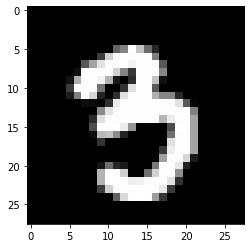

In [37]:
image, label = iter(trainloader).next()
plt.imshow(image[0].reshape((28, 28)), cmap="gray")

In [38]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, X: torch.Tensor):
        X = X.view(-1, 1, 28, 28)
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = F.relu(self.conv3(X))
        X = F.adaptive_avg_pool2d(X, 1)
        return X.view(-1, X.size(1))
    
net = Net().to(device)

In [39]:
net(iter(trainloader).next()[0].to(device))

tensor([[1.2614e+00, 1.6455e-01, 1.6705e+00, 8.2563e-01, 4.2784e-01, 1.2555e+00,
         3.1589e-02, 3.1446e-01, 3.1774e+00, 3.1665e+00],
        [1.1958e+00, 3.8930e-01, 3.2978e+00, 8.7189e-01, 1.1617e+00, 1.3328e+00,
         2.1994e-01, 9.3134e-02, 5.4980e+00, 4.5219e+00],
        [8.8147e-01, 2.6193e-01, 1.9780e+00, 2.4867e-01, 5.0229e-01, 1.0422e+00,
         2.3403e-02, 3.0852e-01, 1.7039e+00, 1.8625e+00],
        [5.8476e-01, 4.3814e-01, 2.1378e+00, 5.9058e-01, 7.4954e-01, 1.0664e+00,
         1.0761e-01, 5.3302e-01, 1.4591e+00, 1.7769e+00],
        [7.6129e-01, 4.8302e-01, 3.6022e+00, 5.8567e-01, 8.2423e-01, 9.2774e-01,
         1.5148e-01, 1.2440e-01, 3.7999e+00, 3.6629e+00],
        [8.5721e-01, 4.6696e-01, 1.6584e+00, 9.9135e-01, 5.1998e-01, 1.1532e+00,
         2.5377e-01, 3.2899e-01, 2.0417e+00, 2.0483e+00],
        [8.6295e-01, 2.8055e-01, 1.8380e+00, 6.5674e-01, 4.2187e-01, 1.0015e+00,
         1.4991e-01, 7.8930e-01, 2.1815e+00, 1.6001e+00],
        [6.9989e-01, 4.8968

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [47]:
for epoch in range(100):
    running_loss = 0.0
    
    for images, labels in iter(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_size
    print(running_loss / len(trainset))

0.06550309717087519
0.06487089565822056
0.06297644617443993
0.06520814645858038
0.06257073674883161
0.06052588853381929
0.0638934934025719
0.061259765193575906
0.06069259298415411
0.05912161279859997
0.06012853926704043
0.059244807901836574
0.057178731600443525
0.05925575385774885
0.05891791384560721
0.05547646120616368
0.056050338699704126
0.05613342555363973
0.05491715129216512
0.05615457082930066


In [48]:
torch.save(net.state_dict(), Path("model") / "mnist_net.pt")

In [52]:
testset = MNISTDataset(Path("data") / "test.csv", train=False)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=2)

net.eval()
predicted = []
for images in iter(testloader):
    images = images.to(device)
    output = net(images)
    predicted += torch.argmax(output, dim=1).tolist()

In [53]:
import csv
with open("submission.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["ImageId", "Label"])
    for i, label in enumerate(predicted, 1):
        writer.writerow([i, label])

